# Emotion Recognition using a CNN model with integrated feature extraction

The code and requirements can be found on GitHub: https://github.com/Ahmet-Toplu/emotion_recognition

# Download data

Download the AffectNET dataset from kaggle, unfortunately kaggle dont let you download the dataset to a specific location so i just moved it to my emotion_recognition folder 

In [3]:
import kagglehub

# Download the dataset
try:
    base_path = kagglehub.dataset_download("fatihkgg/affectnet-yolo-format")
    print("Path to dataset files:", base_path)
except Exception as e:
    print("Error downloading dataset:", e)
    exit()

/opt/anaconda3/envs/CNN_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/alexhofman/.cache/kagglehub/datasets/fatihkgg/affectnet-yolo-format/versions/2


In [4]:
import os
import shutil

# Define paths
source_base_path = os.path.join(base_path, "YOLO_format")  # Add YOLO_format to the downloaded path
destination_base_path = os.path.join(os.getcwd(), "AffectNET")  # Place organized data in 'AffectNET' folder

# Define emotions
emotions = [
    "Anger",
    "Contempt",
    "Disgust",
    "Fear",
    "Happy",
    "Neutral",
    "Sad",
    "Surprise",
]

# Define function to organize files
def organize_affectnet(source_base_path, destination_base_path, split):
    source_images_path = os.path.join(source_base_path, split, "images")
    source_labels_path = os.path.join(source_base_path, split, "labels")

    if not os.path.exists(source_images_path) or not os.path.exists(source_labels_path):
        print(f"Warning: {split} images or labels path does not exist. Skipping.")
        return

    destination_split_path = os.path.join(destination_base_path, f"{split}_organized")

    # Create destination directories for emotions
    for emotion in emotions:
        emotion_folder = os.path.join(destination_split_path, emotion)
        os.makedirs(emotion_folder, exist_ok=True)

    # Move and organize files
    for label_file in os.listdir(source_labels_path):
        if label_file.endswith(".txt"):
            label_path = os.path.join(source_labels_path, label_file)

            # Handle both .jpg and .png image extensions
            image_file_jpg = label_file.replace(".txt", ".jpg")
            image_file_png = label_file.replace(".txt", ".png")

            source_image_path_jpg = os.path.join(source_images_path, image_file_jpg)
            source_image_path_png = os.path.join(source_images_path, image_file_png)

            if os.path.exists(source_image_path_jpg) or os.path.exists(source_image_path_png):
                source_image_path = source_image_path_jpg if os.path.exists(source_image_path_jpg) else source_image_path_png

                with open(label_path, "r") as f:
                    labels = f.readlines()

                for label in labels:
                    label_data = label.strip().split()
                    emotion_index = int(label_data[0])  # Emotion class index
                    if emotion_index < len(emotions):
                        emotion = emotions[emotion_index]
                        destination_image_path = os.path.join(destination_split_path, emotion, os.path.basename(source_image_path))
                        shutil.copy(source_image_path, destination_image_path)
                        break  # Move the image based on the first valid label
            else:
                print(f"Image {image_file_jpg} or {image_file_png} not found for label {label_file}")

# Create the main AffectNET directory
os.makedirs(destination_base_path, exist_ok=True)

# Organize train, valid, and test datasets
for split in ["train", "valid", "test"]:
    organize_affectnet(source_base_path, destination_base_path, split)

print("Dataset organization complete.")



Dataset organization complete.


### Purpose
- Organizes the AffectNet dataset downloaded via KaggleHub into a structured format compatible with the emotion recognition program.
- Moves images into emotion-specific folders (`Anger`, `Happy`, etc.) for training, validation, and testing.

### How it Works
1. **Defines Input and Output Paths**:
   - Takes the original KaggleHub dataset location as `base_path`.
   - Organizes the files into an `AffectNET` folder in the current working directory (`destination_base_path`).
2. **Emotions Mapping**:
   - Maps labels from `labels` files to emotion folder names (`Anger`, `Happy`, etc.).
3. **File Organization**:
   - Reads label files (`.txt`) to identify the emotion associated with each image.
   - Copies images into their respective emotion folders under `train_organized`, `valid_organized`, and `test_organized`.
4. **Error Handling**:
   - Skips missing files and directories, providing warnings in the output.

### Returns
- Creates a folder structure:
  ```
  AffectNET/
    train_organized/
      Anger/
      Contempt/
      ...
    valid_organized/
      Anger/
      Contempt/
      ...
    test_organized/
      Anger/
      Contempt/
      ...
  ```
- Organizes all images and labels into their respective emotion folders for easy use in machine learning pipelines.

# Code Explanation

## Imports
- **`os`**: Used for interacting with the file system (e.g., navigating directories, managing file paths).
- **`tensorflow`**: A deep learning library used for building and training machine learning models.
  - **`Model`**: Represents a neural network model in Keras.
  - **`load_model`**: Loads a saved model from a file.
  - **Layers**:
    - **`Conv2D`**: Convolutional layer for feature extraction.
    - **`MaxPooling2D`**: Down-samples feature maps.
    - **`Flatten`**: Converts multi-dimensional data into a 1D vector.
    - **`Dense`**: Fully connected layer for classification.
    - **`Input`**: Defines the input layer of the model.
    - **`BatchNormalization`**: Normalizes layer outputs for stable training.
- **`numpy`**: Provides numerical operations for array manipulation (used for preprocessing and dataset preparation).
- **`matplotlib.pyplot`**: Used for visualizing images and feature heatmaps.
- **`cv2` (OpenCV)**: Handles image processing and real-time camera feed.
- **`random`**: Used for generating random numbers and selections.
- **`logging`**: Configures logging behavior (e.g., suppresses TensorFlow logs).

In [5]:
import os
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization
)
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
import random
import logging
from PyQt6.QtWidgets import QApplication, QLabel, QHBoxLayout, QVBoxLayout, QPushButton, QWidget
from PyQt6.QtGui import QPixmap
from PyQt6.QtCore import Qt
from PIL import Image, ImageQt

**Purpose**: Limits TensorFlow logs to show only errors, avoiding clutter in the output.

**How it works**: Sets TensorFlow’s logging level to ERROR.

In [6]:
# Suppress TensorFlow progress bar
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [7]:
class DataProcessor:
    def __init__(self, train_path, valid_path, test_path, emotions):
        self.train_path = train_path
        self.valid_path = valid_path
        self.test_path = test_path
        self.emotions = emotions

    def load_affectnet_dataset(self, dataset_path, image_size=(128, 128)):
        images = []
        labels = []

        for label, emotion in enumerate(self.emotions):
            folder_path = os.path.join(dataset_path, emotion)
            if not os.path.exists(folder_path):
                print(f"Warning: Folder {folder_path} does not exist. Skipping.")
                continue

            print(f"Loading images from: {folder_path}")
            for file_name in os.listdir(folder_path):
                if file_name.endswith(".png"):
                    file_path = os.path.join(folder_path, file_name)
                    try:
                        image = cv2.imread(file_path)
                        if image is None:
                            print(f"Warning: Unable to load image {file_path}. Skipping.")
                            continue
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        image = cv2.resize(image, image_size)
                        images.append(image)
                        labels.append(label)
                    except Exception as e:
                        print(f"Error loading image {file_path}: {e}")

        images = np.array(images, dtype="float32") / 255.0
        labels = np.array(labels)

        print(f"Loaded {len(images)} images from {dataset_path}.")
        return images, labels

    def prepare_datasets(self):
        X_train, y_train = self.load_affectnet_dataset(self.train_path)
        X_val, y_val = self.load_affectnet_dataset(self.valid_path)
        X_test, y_test = self.load_affectnet_dataset(self.test_path)

        y_train = to_categorical(y_train, num_classes=len(self.emotions))
        y_val = to_categorical(y_val, num_classes=len(self.emotions))
        y_test = to_categorical(y_test, num_classes=len(self.emotions))

        return X_train, y_train, X_val, y_val, X_test, y_test
    
    def show_example(self, dataset="train", image_size=(128, 128)):
        if dataset == "train":
            dataset_path = self.train_path
        elif dataset == "valid":
            dataset_path = self.valid_path
        elif dataset == "test":
            dataset_path = self.test_path
        else:
            print("Invalid dataset selection. Choose from 'train', 'valid', or 'test'.")
            return

        images, labels = self.load_affectnet_dataset(dataset_path, image_size=image_size)
        if len(images) == 0:
            print("No images found in the dataset.")
            return

        idx = random.randint(0, len(images) - 1)
        image = (images[idx] * 255).astype(np.uint8)
        label = self.emotions[labels[idx]]

        # Display the image in the Jupyter Notebook
        plt.imshow(image)
        plt.title(f"Label: {label}")
        plt.axis('off')
        plt.show()

Loading images from: ./AffectNET/train_organized/Anger
Loading images from: ./AffectNET/train_organized/Contempt
Loading images from: ./AffectNET/train_organized/Disgust
Loading images from: ./AffectNET/train_organized/Fear
Loading images from: ./AffectNET/train_organized/Happy
Loading images from: ./AffectNET/train_organized/Neutral
Loading images from: ./AffectNET/train_organized/Sad
Loading images from: ./AffectNET/train_organized/Surprise
Loaded 4934 images from ./AffectNET/train_organized.


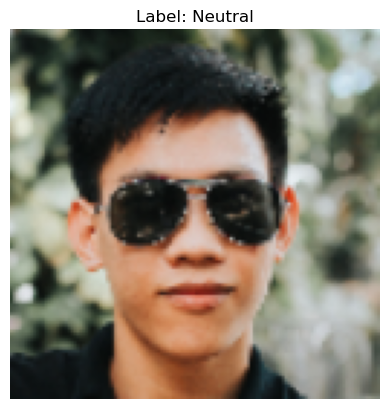

In [8]:
# Test Function for DataProcessor
if __name__ == "__main__":
    TRAIN_PATH = "./AffectNET/train_organized"
    VALID_PATH = "./AffectNET/valid_organized"
    TEST_PATH = "./AffectNET/test_organized"
    EMOTIONS = ["Anger", "Contempt", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

    processor = DataProcessor(TRAIN_PATH, VALID_PATH, TEST_PATH, EMOTIONS)
    processor.show_example(dataset="train")

- **Purpose**: Loads the train, validation, and test datasets and converts their labels to one-hot encoding.
- **How it Works**:
  1. Calls `load_affectnet_dataset` for each dataset (train, validation, test).
  2. Converts the integer labels to one-hot encoded format using `to_categorical`.

- **Returns**:
  - `X_train`, `y_train`: Training images and one-hot encoded labels.
  - `X_val`, `y_val`: Validation images and one-hot encoded labels.
  - `X_test`, `y_test`: Testing images and one-hot encoded labels.

In [9]:
class EmotionCNN:
    def __init__(self, emotions):
        self.emotions = emotions
        self.feature_extractor = None
        self.emotion_classifier = None
        self.combined_model = None

    def build_feature_extractor(self, input_shape=(128, 128, 3)):
        inputs = Input(shape=input_shape)
        x = Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)

        x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)

        x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)

        x = Flatten()(x)
        self.feature_extractor = Model(inputs, x, name="FeatureExtractor")
        return self.feature_extractor

    def build_emotion_classifier(self, input_shape):
        inputs = Input(shape=input_shape)
        x = Dense(256, activation="relu")(inputs)
        x = BatchNormalization()(x)
        x = Dense(128, activation="relu")(x)
        x = BatchNormalization()(x)
        outputs = Dense(len(self.emotions), activation="softmax")(x)
        self.emotion_classifier = Model(inputs, outputs, name="EmotionClassifier")
        return self.emotion_classifier

    def build_combined_model(self):
        # Ensure feature extractor and emotion classifier are initialized
        if self.feature_extractor is None:
            self.build_feature_extractor()
        if self.emotion_classifier is None:
            self.build_emotion_classifier(input_shape=(self.feature_extractor.output_shape[-1],))
            
        inputs = Input(shape=(128, 128, 3))
        features = self.feature_extractor(inputs)
        outputs = self.emotion_classifier(features)
        self.combined_model = Model(inputs, outputs, name="EmotionRecognitionModel")
        return self.combined_model

    def compile_and_train(self, X_train, y_train, X_val, y_val, model_save_path, epochs=10, batch_size=32):
        if os.path.exists(model_save_path):
            print("Loading saved model...")
            self.combined_model = load_model(model_save_path)
        else:
            print("No saved model found. Creating a new model...")
            self.build_feature_extractor()
            self.build_emotion_classifier((self.feature_extractor.output_shape[-1],))
            self.build_combined_model()

            self.combined_model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss="categorical_crossentropy",
                metrics=["accuracy"]
            )
            self.combined_model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size
            )
            self.combined_model.save(model_save_path)
            print(f"Model saved at {model_save_path}") 

    def evaluate_model(self, X_test, y_test):
        if self.combined_model is None:
            print("No model found. Build and compile the model first.")
            return

        test_loss, test_accuracy = self.combined_model.evaluate(X_test, y_test, verbose=0)
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

In [10]:
# Test Function for EmotionCNN
if __name__ == "__main__":
    EMOTIONS = ["Anger", "Contempt", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
    
    # Mock data for testing
    X_test = np.random.rand(10, 128, 128, 3)
    y_test = to_categorical(np.random.randint(0, len(EMOTIONS), size=(10,)), num_classes=len(EMOTIONS))

    emotion_cnn = EmotionCNN(EMOTIONS)
    emotion_cnn.build_feature_extractor()
    emotion_cnn.build_emotion_classifier((emotion_cnn.feature_extractor.output_shape[-1],))
    emotion_cnn.build_combined_model()
    emotion_cnn.combined_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    print("Evaluating model on mock data...")
    emotion_cnn.evaluate_model(X_test, y_test)

Evaluating model on mock data...
Test Loss: 2.0924, Test Accuracy: 20.00%


# Explanation of the EmotionCNN Class

### Purpose
The `EmotionCNN` class is responsible for building, training, and managing a convolutional neural network (CNN) for emotion recognition. It comprises three main components:
- A feature extractor to process images and extract relevant features.
- An emotion classifier to predict emotions based on extracted features.
- A combined model that integrates both the feature extractor and emotion classifier for end-to-end training and inference.

### Methods

#### 1. **`__init__` Method**
Initializes the `EmotionCNN` class and sets up placeholders for the feature extractor, emotion classifier, and combined model.
- **Parameters**: `emotions` (list of emotion labels).

#### 2. **`build_feature_extractor` Method**
Builds the feature extractor part of the CNN, which extracts meaningful features from input images.
- **Purpose**: To create a convolutional network with three convolutional layers, each followed by batch normalization and max-pooling.
- **Input**: Image tensor of shape `(128, 128, 3)`.
- **How It Works**:
  - Convolutional layers (`Conv2D`) extract spatial features.
  - `BatchNormalization` stabilizes training and improves convergence.
  - `MaxPooling2D` reduces spatial dimensions to focus on high-level features.
  - `Flatten` prepares the output for fully connected layers.
- **Output**: A Keras `Model` object representing the feature extractor.

#### 3. **`build_emotion_classifier` Method**
Builds the emotion classifier, which maps extracted features to emotion labels.
- **Purpose**: To create a fully connected network for classification.
- **Input**: Flattened feature tensor.
- **How It Works**:
  - Dense layers (`Dense`) process extracted features with `ReLU` activations.
  - `BatchNormalization` improves stability.
  - Final dense layer outputs probabilities for each emotion using `softmax` activation.
- **Output**: A Keras `Model` object representing the emotion classifier.

#### 4. **`build_combined_model` Method**
Combines the feature extractor and emotion classifier into a single end-to-end model.
- **Purpose**: To allow training and inference in a unified model.
- **How It Works**: The feature extractor processes input images, and the emotion classifier predicts emotions based on the extracted features.
- **Output**: A Keras `Model` object representing the combined model.

#### 5. **`compile_and_train` Method**
Compiles and trains the combined model or loads a pre-trained model if available.
- **Purpose**: To train the model on the provided dataset or use a pre-trained model for further evaluation.
- **Parameters**:
  - `X_train`, `y_train`: Training data and labels.
  - `X_val`, `y_val`: Validation data and labels.
  - `model_save_path`: Path to save the trained model.
  - `epochs`, `batch_size`: Training hyperparameters.
- **How It Works**:
  - Checks if a pre-trained model exists at `model_save_path`.
  - If not, builds the feature extractor, emotion classifier, and combined model.
  - Compiles the model using the Adam optimizer and categorical crossentropy loss.
  - Trains the model using the provided dataset.
  - Saves the trained model to `model_save_path`.
- **Returns**: Trained model (or loaded model if already available).

In [26]:
class FeatureExtraction:
    @staticmethod
    def visualize_features(image, feature_extractor):
        if feature_extractor is None:
            raise ValueError("Feature extractor is not initialized.")

        # Predict feature map
        features = feature_extractor.predict(np.expand_dims(image, axis=0), verbose=0)

        # Get the last convolutional layer output if available
        if len(features.shape) > 2:
            feature_map = features.reshape((features.shape[1], features.shape[2], -1))
        else:
            feature_map = features.reshape((16, 16, -1))  # Fallback for simple models

        # Aggregate feature maps (e.g., use maximum instead of mean)
        feature_map_aggregated = np.max(feature_map, axis=-1)  # Use max pooling to highlight strong activations

        # Normalize the feature map for visualization
        feature_map_normalized = (feature_map_aggregated - feature_map_aggregated.min()) / (
            feature_map_aggregated.max() - feature_map_aggregated.min() + 1e-10
        )

        # Resize feature map to match the input image size
        feature_map_rescaled = cv2.resize(feature_map_normalized, (image.shape[1], image.shape[0]))

        # Create heatmap
        heatmap = cv2.applyColorMap((feature_map_rescaled * 255).astype(np.uint8), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

        # Overlay the heatmap on the original image
        overlay_image = cv2.addWeighted((image * 255).astype(np.uint8), 0.6, heatmap, 0.4, 0)
        return overlay_image, heatmap


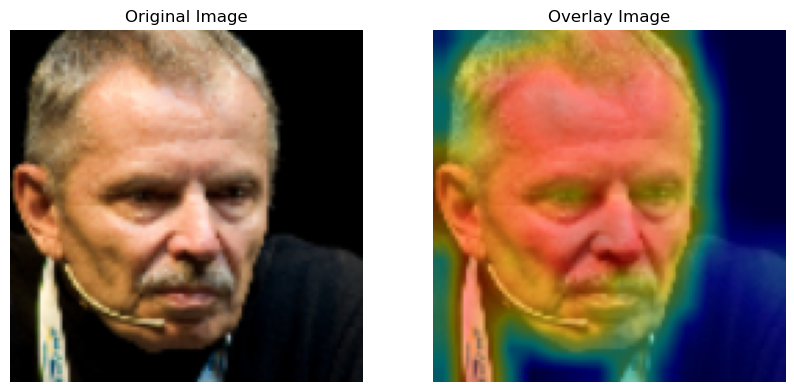

In [28]:
# Test Function for FeatureExtraction
if __name__ == "__main__":
    EMOTIONS = ["Anger", "Contempt", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

    # Load a real image for testing
    dataset_path = "./AffectNET/train_organized"
    example_image_path = None

    for emotion in EMOTIONS:
        emotion_path = os.path.join(dataset_path, emotion)
        if os.path.exists(emotion_path):
            images = [os.path.join(emotion_path, img) for img in os.listdir(emotion_path) if img.endswith(".png")]
            if images:
                example_image_path = random.choice(images)
                break

    if example_image_path:
        image = cv2.imread(example_image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128, 128)) / 255.0

        overlay_image, heatmap = FeatureExtraction.visualize_features(image, feature_extractor)

        # Display results in Jupyter
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(overlay_image)
        plt.title("Overlay Image")
        plt.axis("off")

        plt.show()
    else:
        print("No valid images found for testing.")


# Explanation of the FeatureExtraction Class

### Purpose
The `FeatureExtraction` class provides a static method to visualize features extracted by a pre-trained feature extractor model. This is helpful for understanding what parts of an input image the model focuses on during processing.

### Methods

#### **`visualize_features` Method**
Visualizes the features extracted from an image by creating a heatmap overlay.

- **Parameters**:
  - `image`: Input image (assumed to be preprocessed and resized to match the model's input shape).
  - `feature_extractor`: A pre-trained feature extractor model.

- **How It Works**:
  1. **Feature Extraction**:
     - Passes the image through the `feature_extractor` (a pre-trained model) to obtain the feature map.
     - The feature map is reshaped to its original dimensions (e.g., `16x16xN` for a 16x16 spatial resolution with `N` channels).
  2. **Aggregation**:
     - Aggregates the feature map across channels by taking the mean, resulting in a 2D spatial representation.
  3. **Normalization**:
     - Normalizes the aggregated feature map to the range `[0, 1]` for visualization.
  4. **Resizing**:
     - Rescales the normalized feature map to the original image size (`128x128` by default).
  5. **Heatmap Generation**:
     - Converts the feature map into a heatmap using OpenCV’s `COLORMAP_JET`.
     - Converts the heatmap from BGR to RGB format.
  6. **Overlay Creation**:
     - Blends the heatmap with the original image to create an overlay that highlights regions of high activation.

- **Returns**:
  - `overlay_image`: The input image with the heatmap overlaid.
  - `heatmap`: The generated heatmap, useful for standalone visualization. 

By leveraging a pre-trained feature extraction model, this class enables the analysis of how well the model identifies critical regions in input images.


In [29]:
class EmotionDetectionSystem:
    def __init__(self, train_path, valid_path, test_path, emotions, model_save_path):
        self.data_processor = DataProcessor(train_path, valid_path, test_path, emotions)
        self.emotion_cnn = EmotionCNN(emotions)
        self.model_save_path = model_save_path
        self.dataset, self.labels = self.data_processor.load_affectnet_dataset(train_path)

        # Ensure the feature extractor is built
        if self.emotion_cnn.feature_extractor is None:
            self.emotion_cnn.build_feature_extractor()

    def run(self):
        # Prepare data
        X_train, y_train, X_val, y_val, X_test, y_test = self.data_processor.prepare_datasets()

        # Train or load model
        self.emotion_cnn.compile_and_train(X_train, y_train, X_val, y_val, self.model_save_path)

        # Evaluate model
        test_loss, test_accuracy = self.emotion_cnn.combined_model.evaluate(X_test, y_test, verbose=0)
        print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

        # Live feed for emotion detection
        # self.live_camera_feed()

        # Visualize images with GUI
        self.visualize_images_with_gui()

    def live_camera_feed(self):
        cap = cv2.VideoCapture(0)

        if not cap.isOpened():
            print("Error: Camera not found or cannot be opened.")
            return

        cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
        cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

        cv2.namedWindow("Emotion Recognition", cv2.WINDOW_NORMAL)
        cv2.resizeWindow("Emotion Recognition", 1280, 720)

        print("Press 'q' to quit.")
        while True:
            ret, frame = cap.read()
            if not ret:
                print("Error: Unable to read frame from camera.")
                break

            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_normalized = frame_rgb / 255.0
            frame_resized = cv2.resize(frame_normalized, (128, 128))

            prediction = self.emotion_cnn.combined_model.predict(np.expand_dims(frame_resized, axis=0), verbose=0)
            predicted_emotion = self.data_processor.emotions[np.argmax(prediction)]

            cv2.putText(
                frame,
                f"Emotion: {predicted_emotion}",
                (10, 50),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (0, 255, 0),
                2,
                cv2.LINE_AA,
            )

            cv2.imshow("Emotion Recognition", frame)

            if cv2.waitKey(1) & 0xFF == ord('q') or cv2.getWindowProperty("Emotion Recognition", cv2.WND_PROP_VISIBLE) < 1:
                break

        cap.release()
        cv2.destroyAllWindows()

    def visualize_images_with_gui(self):
        class EmotionViewer(QWidget):
            def __init__(self, dataset, labels, emotions, feature_extractor, combined_model, parent=None):
                super().__init__(parent)
                self.dataset = dataset
                self.labels = labels
                self.emotions = emotions
                self.feature_extractor = feature_extractor
                self.combined_model = combined_model
                self.init_ui()

            def init_ui(self):
                self.setWindowTitle("Emotion Recognition Viewer")

                # Layout setup
                self.layout = QVBoxLayout()
                self.image_layout = QHBoxLayout()

                self.original_image_label = QLabel()
                self.original_image_label.setAlignment(Qt.AlignmentFlag.AlignCenter)
                self.overlay_image_label = QLabel()
                self.overlay_image_label.setAlignment(Qt.AlignmentFlag.AlignCenter)

                self.image_layout.addWidget(self.original_image_label)
                self.image_layout.addWidget(self.overlay_image_label)

                self.label_layout = QHBoxLayout()
                self.original_label = QLabel("Original Image")
                self.overlay_label = QLabel("Image with Overlay")

                self.label_layout.addWidget(self.original_label)
                self.label_layout.addWidget(self.overlay_label)

                self.next_button = QPushButton("Next Image")
                self.next_button.clicked.connect(self.load_next_image)

                self.layout.addLayout(self.image_layout)
                self.layout.addLayout(self.label_layout)
                self.layout.addWidget(self.next_button)

                self.setLayout(self.layout)
                self.load_next_image()

            def load_next_image(self):
                idx = random.randint(0, len(self.dataset) - 1)
                image = self.dataset[idx]
                label = self.emotions[self.labels[idx]]

                # Get the model's prediction
                prediction = self.combined_model.predict(np.expand_dims(image, axis=0), verbose=0)
                guessed_emotion = self.emotions[np.argmax(prediction)]

                # Convert original image
                original_image = (image * 255).astype(np.uint8)  # Scale to 0-255
                original_image_pil = Image.fromarray(original_image)
                original_qpixmap = QPixmap.fromImage(ImageQt.ImageQt(original_image_pil))
                self.original_image_label.setPixmap(original_qpixmap)

                # Create overlay
                if self.feature_extractor is not None:
                    try:
                        overlay_image, _ = FeatureExtraction.visualize_features(image, self.feature_extractor)
                        overlay_image_pil = Image.fromarray(overlay_image)
                        overlay_qpixmap = QPixmap.fromImage(ImageQt.ImageQt(overlay_image_pil))
                        self.overlay_image_label.setPixmap(overlay_qpixmap)
                    except Exception as e:
                        print(f"Error in generating overlay: {e}")
                        self.overlay_image_label.clear()

                # Update labels
                self.original_label.setText(f"Original Image (Label: {label})")
                self.overlay_label.setText(f"Image with Overlay (Guessed: {guessed_emotion})")

        app = QApplication([])
        viewer = EmotionViewer(self.dataset, self.labels, self.data_processor.emotions, self.emotion_cnn.feature_extractor, self.emotion_cnn.combined_model)
        viewer.show()
        app.exec()


Loading images from: ./AffectNET/train_organized/Anger
Loading images from: ./AffectNET/train_organized/Contempt
Loading images from: ./AffectNET/train_organized/Disgust
Loading images from: ./AffectNET/train_organized/Fear
Loading images from: ./AffectNET/train_organized/Happy
Loading images from: ./AffectNET/train_organized/Neutral
Loading images from: ./AffectNET/train_organized/Sad
Loading images from: ./AffectNET/train_organized/Surprise
Loaded 4934 images from ./AffectNET/train_organized.


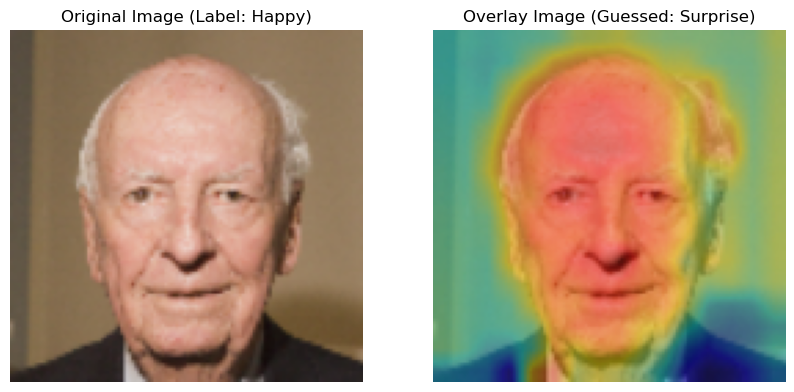

In [30]:
# Test Function for EmotionDetectionSystem
if __name__ == "__main__":
    TRAIN_PATH = "./AffectNET/train_organized"
    VALID_PATH = "./AffectNET/valid_organized"
    TEST_PATH = "./AffectNET/test_organized"
    EMOTIONS = ["Anger", "Contempt", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
    MODEL_SAVE_PATH = "emotion_recognition_model.h5"

    system = EmotionDetectionSystem(TRAIN_PATH, VALID_PATH, TEST_PATH, EMOTIONS, MODEL_SAVE_PATH)

    # Ensure feature extractor and classifier are initialized
    if system.emotion_cnn.combined_model is None:
        system.emotion_cnn.build_combined_model()

    # Show an example image and its overlay with predictions
    random_idx = random.randint(0, len(system.dataset) - 1)
    example_image = system.dataset[random_idx]
    label = system.data_processor.emotions[system.labels[random_idx]]

    # Get prediction and overlay
    prediction = system.emotion_cnn.combined_model.predict(np.expand_dims(example_image, axis=0), verbose=0)
    guessed_emotion = system.data_processor.emotions[np.argmax(prediction)]
    overlay_image, _ = FeatureExtraction.visualize_features(example_image, system.emotion_cnn.feature_extractor)

    # Display the results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow((example_image * 255).astype(np.uint8))
    plt.title(f"Original Image (Label: {label})")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay_image)
    plt.title(f"Overlay Image (Guessed: {guessed_emotion})")
    plt.axis("off")

    plt.show()


# Explanation of the EmotionDetectionSystem Class

### Purpose
The `EmotionDetectionSystem` class integrates data preparation, model training, evaluation, live camera-based emotion detection, and a graphical interface for visualizing predictions into a single system. It acts as the main interface for running the emotion recognition pipeline.

### Methods

#### **`__init__` Method**
Initializes the `EmotionDetectionSystem` class and sets up the components.
- **Parameters**:
  - `train_path`, `valid_path`, `test_path`: Paths to the training, validation, and testing datasets.
  - `emotions`: List of emotion labels.
  - `model_save_path`: File path to save or load the trained model.
- **Components Initialized**:
  - `DataProcessor`: Handles data loading and preprocessing.
  - `EmotionCNN`: Builds, trains, and manages the emotion recognition CNN.

#### **`run` Method**
Executes the full pipeline: data preparation, model training/loading, evaluation, and live camera detection.
- **Steps**:
  1. Prepares datasets using `DataProcessor.prepare_datasets`.
  2. Trains or loads the emotion recognition model via `EmotionCNN.compile_and_train`.
  3. Evaluates the trained model on the test dataset and prints the test accuracy.
  4. Launches the live camera feed for real-time emotion detection.
  5. Opens the GUI to visualize dataset images and predictions.

#### **`live_camera_feed` Method**
Captures video from a webcam and performs real-time emotion recognition.
- **How It Works**:
  1. **Camera Initialization**:
     - Opens the webcam using OpenCV (`cv2.VideoCapture`).
     - Sets the video resolution to 1280x720.
  2. **Frame Processing**:
     - Captures each frame from the webcam.
     - Converts the frame to RGB format and normalizes pixel values.
     - Resizes the frame to match the model input size (128x128).
  3. **Emotion Prediction**:
     - Passes the preprocessed frame through the trained model to get emotion predictions.
     - Extracts the predicted emotion label.
  4. **Display**:
     - Overlays the predicted emotion label on the video feed using `cv2.putText`.
     - Displays the video feed in a resizable OpenCV window.
  5. **Exit Conditions**:
     - Closes the video feed when the user presses 'q' or clicks the close button on the window.
- **Error Handling**:
  - If the camera cannot be opened, an error message is printed.
  - Handles cases where frames cannot be read from the camera.

#### **`visualize_images_with_gui` Method**
Provides a graphical interface for visualizing dataset images and their associated predictions.

- **How It Works**:
  1. **GUI Initialization**:
     - A PyQt6-based application displays two images side by side:
       - The original image with its true emotion label.
       - An overlay image showing the predicted emotion and feature extraction heatmap.
  2. **Image Navigation**:
     - Includes a "Next Image" button to cycle through random images in the dataset.
  3. **Emotion Prediction**:
     - Uses the trained model to predict the emotion for each image.
  4. **Feature Extraction**:
     - Visualizes feature activations using the `FeatureExtraction.visualize_features` method.
  5. **Dynamic Display**:
     - Updates the GUI dynamically to reflect the selected image and its predictions.

- **User Experience**:
  - The GUI includes:
    - Labels for "Original Image" and "Image with Overlay".
    - A button to load a new random image for visualization.
  - The overlay image highlights regions the model focused on during prediction.

- **Purpose**:
  - Allows users to visually inspect the model's predictions and understand its focus through feature maps.

By combining these functionalities, the `EmotionDetectionSystem` provides a comprehensive pipeline for emotion recognition, including real-time predictions and detailed visualizations.


In [31]:
if __name__ == "__main__":
    TRAIN_PATH = "./AffectNET/train_organized"
    VALID_PATH = "./AffectNET/valid_organized"
    TEST_PATH = "./AffectNET/test_organized"
    EMOTIONS = ["Anger", "Contempt", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
    MODEL_SAVE_PATH = "emotion_recognition_model.h5"

    system = EmotionDetectionSystem(TRAIN_PATH, VALID_PATH, TEST_PATH, EMOTIONS, MODEL_SAVE_PATH)
    system.run()

Loading images from: ./AffectNET/train_organized/Anger
Loading images from: ./AffectNET/train_organized/Contempt
Loading images from: ./AffectNET/train_organized/Disgust
Loading images from: ./AffectNET/train_organized/Fear
Loading images from: ./AffectNET/train_organized/Happy
Loading images from: ./AffectNET/train_organized/Neutral
Loading images from: ./AffectNET/train_organized/Sad
Loading images from: ./AffectNET/train_organized/Surprise
Loaded 4934 images from ./AffectNET/train_organized.
Loading images from: ./AffectNET/train_organized/Anger
Loading images from: ./AffectNET/train_organized/Contempt
Loading images from: ./AffectNET/train_organized/Disgust
Loading images from: ./AffectNET/train_organized/Fear
Loading images from: ./AffectNET/train_organized/Happy
Loading images from: ./AffectNET/train_organized/Neutral
Loading images from: ./AffectNET/train_organized/Sad
Loading images from: ./AffectNET/train_organized/Surprise
Loaded 4934 images from ./AffectNET/train_organized.


Loaded 1003 images from ./AffectNET/test_organized.
Loading saved model...
Test Accuracy: 52.04%


2025-01-05 17:17:18.363 python[22901:6662237] +[IMKClient subclass]: chose IMKClient_Modern
2025-01-05 17:17:18.363 python[22901:6662237] +[IMKInputSession subclass]: chose IMKInputSession_Modern
